# Penovate Project using Hybrid CNN-LSTM Model

### Importing Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

### Defining the  CNN-LSTM Model

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size=18, hidden_size=128, num_classes=26, dropout_rate=0.3):
        super(CNN_LSTM, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)  
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)  
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)

        self.fc1 = nn.Linear(hidden_size * 2, 128)  # Bidirectional LSTM doubles hidden size
        self.dropout = nn.Dropout(dropout_rate)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = torch.relu(self.bn1(self.conv1(x))) 
        x = self.pool(torch.relu(self.bn2(self.conv2(x)))) 

        x = x.permute(0, 2, 1)  
        x, _ = self.lstm(x)
        x = x[:, -1, :]  

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

### Data Loading & Preprocessing

In [ ]:
def load_data(data_directory):
    """
    Load the dataset from the specified directory.
    Convert labels to numerical format using Label Encoding.
    """
    X_train = np.load(os.path.join(data_directory, 'X_train.npy'))
    X_val = np.load(os.path.join(data_directory, 'X_val.npy'))
    X_test = np.load(os.path.join(data_directory, 'X_test.npy'))
    y_train = np.load(os.path.join(data_directory, 'y_train.npy'))
    y_val = np.load(os.path.join(data_directory, 'y_val.npy'))
    y_test = np.load(os.path.join(data_directory, 'y_test.npy'))

    label_encoder = LabelEncoder()
    unique_labels = np.unique(np.concatenate([y_train, y_val, y_test]))
    label_encoder.fit(unique_labels)

    y_train = label_encoder.transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)

    np.save(os.path.join(data_directory, 'label_encoder.npy'), label_encoder.classes_)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder


### Training Function with Scheduler

In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=30):
    """
    Train the CNN-LSTM model with CrossEntropy loss and Adam optimizer.
    Learning rate scheduler adjusts learning rate every 10 epochs.
    Saves the training and validation loss and accuracy to arrays.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
    model.to(device)

    best_val_acc = 0.0  

   
    training_metrics = [] 
    for epoch in range(epochs):
        model.train()
        correct_preds, total_preds = 0, 0
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == targets).sum().item()
            total_preds += targets.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds

        model.eval()
        correct_val, total_val = 0, 0
        val_loss = 0.0  
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()  

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)

        val_loss /= len(val_loader)  
        val_accuracy = correct_val / total_val

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        training_metrics.append([train_loss, train_accuracy, val_loss, val_accuracy])

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_cnn_lstm.pth')

        scheduler.step()

    return training_metrics

### Model Execution

In [ ]:
if __name__ == "__main__":
    DATA_DIR = "" 
    print("Loading data...")
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = load_data(DATA_DIR)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN_LSTM().to(device)

    print("Training model...")
    training_metrics = train_model(model, train_loader, val_loader, device)

    torch.save(model.state_dict(), 'cnn_lstm_model.pth')

Loading data...
Training model...
Epoch 1/30 | Train Loss: 3.2620 | Train Acc: 0.0311 | Val Loss: 3.2586 | Val Acc: 0.0385
Epoch 2/30 | Train Loss: 3.2605 | Train Acc: 0.0388 | Val Loss: 3.2587 | Val Acc: 0.0385
Epoch 3/30 | Train Loss: 3.2601 | Train Acc: 0.0385 | Val Loss: 3.2583 | Val Acc: 0.0385
Epoch 4/30 | Train Loss: 3.2597 | Train Acc: 0.0333 | Val Loss: 3.2580 | Val Acc: 0.0385
Epoch 5/30 | Train Loss: 3.2590 | Train Acc: 0.0392 | Val Loss: 3.2571 | Val Acc: 0.0414
Epoch 6/30 | Train Loss: 3.2650 | Train Acc: 0.0392 | Val Loss: 3.2573 | Val Acc: 0.0385
Epoch 7/30 | Train Loss: 3.2590 | Train Acc: 0.0377 | Val Loss: 3.2575 | Val Acc: 0.0385
Epoch 8/30 | Train Loss: 3.2557 | Train Acc: 0.0396 | Val Loss: 3.2585 | Val Acc: 0.0385
Epoch 9/30 | Train Loss: 3.0794 | Train Acc: 0.0658 | Val Loss: 2.8024 | Val Acc: 0.1302
Epoch 10/30 | Train Loss: 2.7828 | Train Acc: 0.1050 | Val Loss: 2.5766 | Val Acc: 0.1272
Epoch 11/30 | Train Loss: 2.6172 | Train Acc: 0.1413 | Val Loss: 2.5216 | V

### Testing Loop 

In [ ]:
test_metrics = {}

criterion = nn.CrossEntropyLoss()
model.eval()  

model.load_state_dict(torch.load('best_cnn_lstm.pth'))
model.eval()

correct_test, total_test = 0, 0
test_loss = 0.0  

with torch.no_grad():  
    for inputs, targets in test_loader:  
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        test_loss += loss.item()  

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == targets).sum().item()
        total_test += targets.size(0)

test_loss /= len(test_loader)
test_accuracy = correct_test / total_test
test_metrics["Test Set"] = [test_loss, test_accuracy]

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2781 | Test Accuracy: 0.9408


### Model Evaluation & Visualization

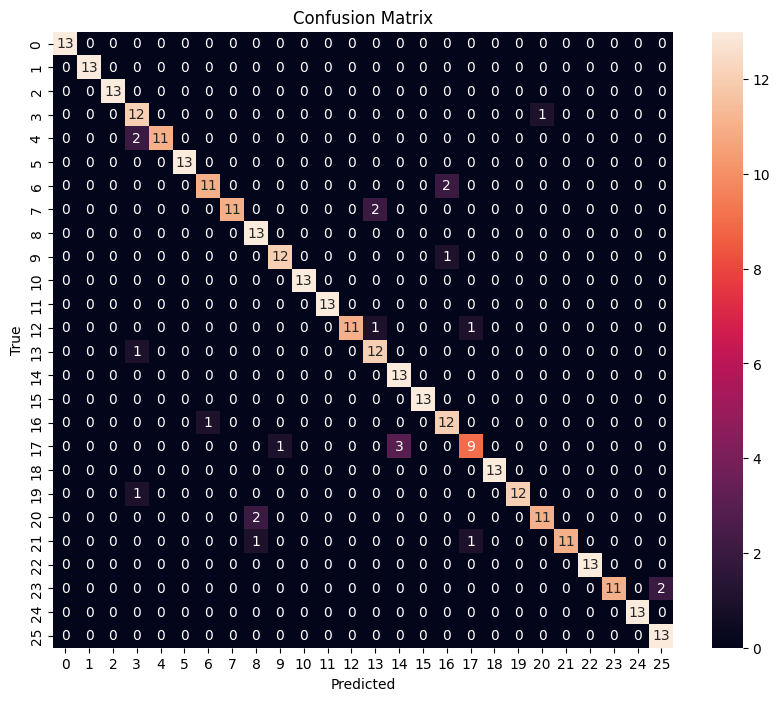


Classification Report:
Accuracy: 93.20%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13
           3       0.75      0.92      0.83        13
           4       1.00      0.85      0.92        13
           5       1.00      1.00      1.00        13
           6       0.92      0.85      0.88        13
           7       1.00      0.85      0.92        13
           8       0.81      1.00      0.90        13
           9       0.92      0.92      0.92        13
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        13
          12       1.00      0.85      0.92        13
          13       0.80      0.92      0.86        13
          14       0.81      1.00      0.90        13
          15       1.00      1.00      1.00        13
          16       0.80      0.92      0

In [ ]:
model.load_state_dict(torch.load('cnn_lstm_model.pth'))
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

accuracy = (np.array(y_pred) == np.array(y_true)).mean() * 100

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()


print("\nClassification Report:")
target_names = label_encoder.classes_  
target_names = [str(name) for name in target_names]  
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))


### Plot Training and Validation Loss/Accuracy

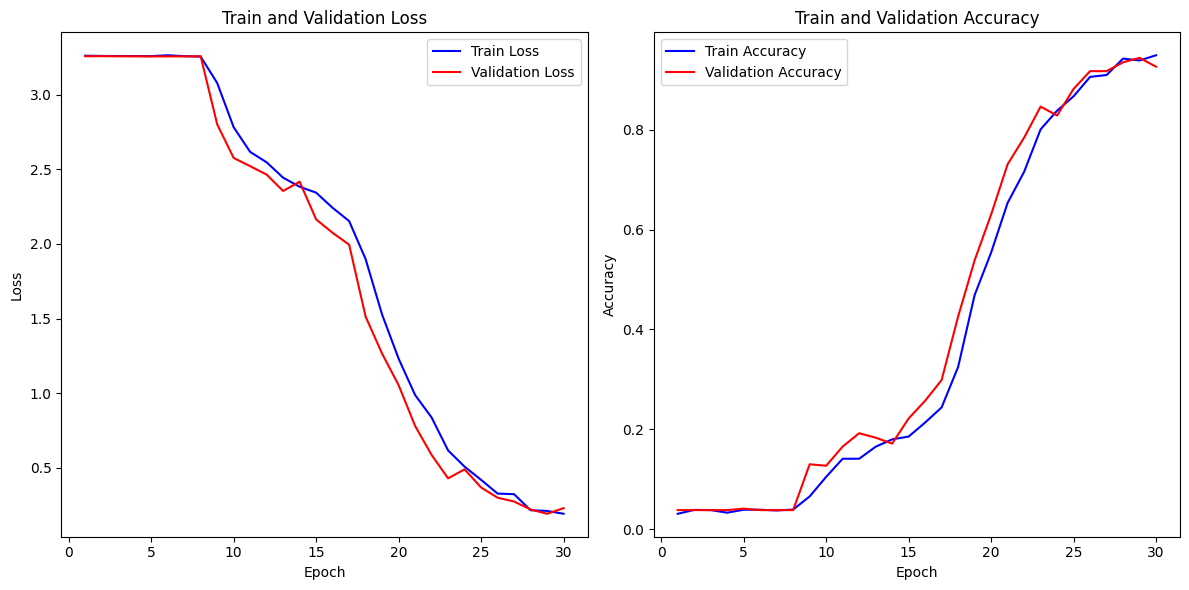

In [ ]:
epochs = range(1, len(training_metrics) + 1)

train_losses, train_accuracies, val_losses, val_accuracies = zip(*training_metrics)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('tight_layout.png')
plt.show()
